# 0. 사용할 패키지 불러오기

In [1]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.layers.core import Flatten
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.models import load_model
import cv2


# 1. 데이터 불러오기

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [87]:
import numpy as np
import glob
import sys
from sklearn.model_selection import train_test_split

x_train = np.empty((0, 180, 240, 3))
y_train = np.empty((0, 3))
print(y_train.shape)

training_data = glob.glob('/home/pirl/front4odi_final_data/*.npz')

x_train = []
cnt_data={0:0,1:0,2:0}
for single_npz in training_data:
    with np.load(single_npz) as data:
        #print(data.files)
        x = data['train']
        try :
            y = data['trining_label']

        except KeyError :  # 에러 종류
            y = data['training_label']
        print(x.shape)
        '''for i in range(x.shape[0]):
            tmp = x[i]
            temp=cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY) # convert color to gray
            x = np.reshape(temp, ( -1, 180, 240, 1))
            
            x_train = np.vstack((x_train, x))'''
        
        temp_list = []
        print("x.shape is ",x.shape)
        for i in x:
            #print(i.shape)
#           temp=cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
            temp_list.append(np.reshape(i, (180, 240, 3)))
            y_train = np.vstack((y_train, y))   
            cnt_data[np.argmax(y)]+=1

        x_train.extend(temp_list)
        
x_train = np.array(x_train)        
print(x_train.shape)
print(y_train.shape)
# train test split, 7:3
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state = 42)

y_train = y_train[:,:]
y_test = y_test[:,:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(0, 3)
(11251, 240, 180, 3)
x.shape is  (11251, 240, 180, 3)
(10083, 240, 180, 3)
x.shape is  (10083, 240, 180, 3)
(8619, 240, 180, 3)
x.shape is  (8619, 240, 180, 3)
(759, 240, 180, 3)
x.shape is  (759, 240, 180, 3)
(630, 240, 180, 3)
x.shape is  (630, 240, 180, 3)
(1509, 240, 180, 3)
x.shape is  (1509, 240, 180, 3)
(758, 240, 180, 3)
x.shape is  (758, 240, 180, 3)
(609, 240, 180, 3)
x.shape is  (609, 240, 180, 3)
(34218, 180, 240, 3)
(34218, 3)
(23952, 180, 240, 3) (23952, 3)
(10266, 180, 240, 3) (10266, 3)


In [88]:
cnt_data

{0: 11251, 1: 11322, 2: 11645}

# 데이터 확인

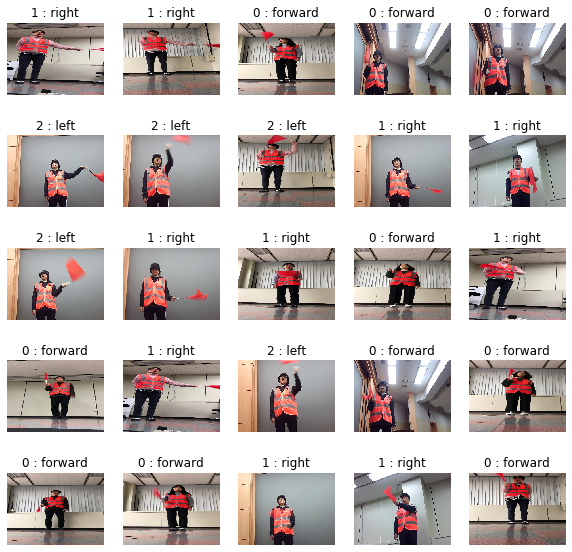

In [95]:
# 데이터 확인
from matplotlib import pyplot as plt
import random
%matplotlib inline

plt_row = 5
plt_col = 5
plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)
idx = random.sample(range(x_train.shape[0]), 25)

for i in range(plt_row*plt_col):

    sub_plt = axarr[int(i/plt_row), int(i%plt_col)]
    sub_plt.axis('off')
    #sub_plt.imshow(x_train[i].reshape(180, 240,3))
    sub_plt.imshow(x_train[idx[i]].reshape(180,240,3))
    #label = np.argmax(y_train[i])
    label = np.argmax(y_train[idx[i]])                 
    if label == 2 :
        direction = 'left'
    elif label == 1:
        direction = 'right'
    elif label == 0:
        direction = 'forward'
                      
    sub_plt_title = str(label) + " : " + direction
    sub_plt.set_title(sub_plt_title)

plt.show()

# 3. 모델 생성

In [96]:
# image size = 160 x 320
def posla_net():
    
    # model setting
    H = 180
    W = 240
    CH = 3


    inputShape = (H, W, CH)

    activation = 'relu'
    keep_prob_conv = 0.25
    keep_prob_dense = 0.5

    #init = 'glorot_normal'
    #init = 'he_normal'
    init = 'he_uniform'
    chanDim = -1
    classes = 3
    
    model = Sequential()
    
    # CONV => RELU => POOL
    model.add(Conv2D(3, (3, 3), padding="valid", input_shape=inputShape, kernel_initializer=init, activation=activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(9, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(18, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(80, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    model.add(Dense(15, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    # softmax classifier
    model.add(Dense(classes , activation = 'softmax'))
    
    return model

In [97]:
model = posla_net()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 178, 238, 3)       84        
_________________________________________________________________
batch_normalization_3 (Batch (None, 178, 238, 3)       12        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 89, 119, 3)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 87, 117, 9)        252       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 58, 9)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 41, 56, 18)        1476      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 20, 28, 18)        0         
__________

In [63]:
# from tensorflow.python.keras.utils import plot_model
# plot_model(model, to_file= 'video_net_plot.png', show_shapes = True, show_layer_names = True)

# 4. 모델 파라미터 셋팅

적은 수의 이미지 데이터가 존재할 경우 데이터를 늘리는 용도로 사용

In [98]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [99]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [100]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [101]:
# initialize the model
# EPOCHS = 50
# INIT_LR = 1e-3
# BS = 32
# split_ratio = 0.2

In [102]:
EPOCHS = 10
INIT_LR = 1e-3
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 

[INFO] compiling model...


# 5. 모델 훈련

In [103]:
from tensorflow.keras.utils import to_categorical


In [104]:
y_binary = to_categorical(y_train)

In [105]:
hist = model.fit(x_train, y_train, 
                 epochs=EPOCHS, batch_size=BS, 
                 validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Train on 19161 samples, validate on 4791 samples
Epoch 1/10
19161/19161 [==============================] - 27s 1ms/step - loss: 0.7394 - acc: 0.6872 - val_loss: 0.1099 - val_acc: 0.9593
Epoch 2/10
19161/19161 [==============================] - 24s 1ms/step - loss: 0.2626 - acc: 0.8867 - val_loss: 0.0319 - val_acc: 0.9891
Epoch 3/10
19161/19161 [==============================] - 24s 1ms/step - loss: 0.1585 - acc: 0.9297 - val_loss: 0.0095 - val_acc: 0.9975
Epoch 4/10
19161/19161 [==============================] - 24s 1ms/step - loss: 0.1170 - acc: 0.9475 - val_loss: 0.0068 - val_acc: 0.9983
Epoch 5/10
19161/19161 [==============================] - 24s 1ms/step - loss: 0.0937 - acc: 0.9565 - val_loss: 0.0057 - val_acc: 0.9990
Epoch 6/10
19161/19161 [==============================] - 24s 1ms/step - loss: 0.0848 - acc: 0.9570 - val_loss: 0.0037 - val_acc: 0.9992
Epoch 7/10
19161/19161 [==============================] - 24s 1ms/step - loss: 0.0781 - acc: 0.9591 - val_loss: 0.0029 - val_acc:

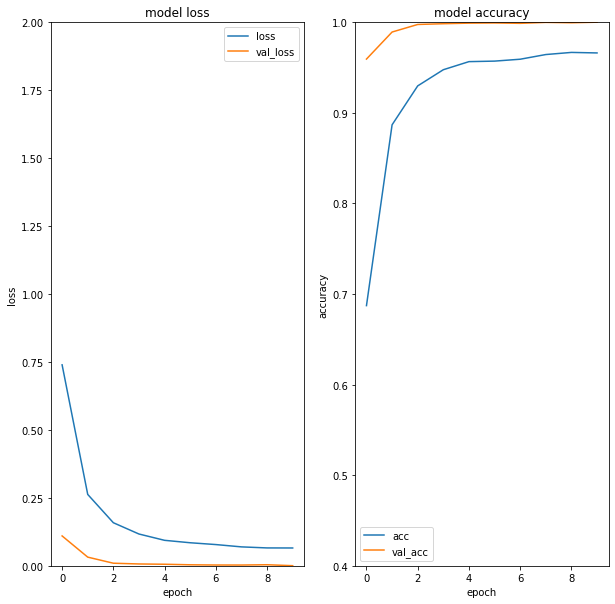

In [107]:
plt.subplot(1, 2, 1)
plt.title('model loss')

plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0,2))

plt.subplot(1, 2, 2)
plt.title('model accuracy')
plt.plot(hist.history['acc'], label="acc")
plt.plot(hist.history['val_acc'], label="val_acc")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0.4, 1))


plt.show();

# 6. 모델 결과 확인

In [25]:
#l_model = load_model('./model_data/VGG_model.h5')

In [108]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

10266/10266 [==============================] - 9s 857us/step
## evaluation loss and_metrics ##
[0.000172251933055958, 1.0]


In [109]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 2, Predict : 2
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 2, Predict : 2
True : 0, Predict : 0
True : 0, Predict : 0
True : 1, Predict : 1
True : 2, Predict : 2
True : 1, Predict : 1


# 7. 최종 모델 훈련

In [110]:
x_total = np.vstack((x_train, x_test))
y_total = np.vstack((y_train, y_test))

print(x_total.shape)
print(y_total.shape)

(34218, 180, 240, 3)
(34218, 3)


In [111]:
early_stopping = EarlyStopping(monitor='loss', patience=10)

In [112]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [113]:
EPOCHS = 10
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [114]:
hist = model.fit(x_total, y_total, 
                 epochs=EPOCHS, batch_size=BS, 
                 #validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Epoch 1/10
34218/34218 [==============================] - 38s 1ms/step - loss: 0.0581 - acc: 0.9685
Epoch 2/10
34218/34218 [==============================] - 36s 1ms/step - loss: 0.0563 - acc: 0.9699
Epoch 3/10
34218/34218 [==============================] - 36s 1ms/step - loss: 0.0560 - acc: 0.9693
Epoch 4/10
34218/34218 [==============================] - 36s 1ms/step - loss: 0.0528 - acc: 0.9720
Epoch 5/10
34218/34218 [==============================] - 36s 1ms/step - loss: 0.0533 - acc: 0.9719
Epoch 6/10
34218/34218 [==============================] - 36s 1ms/step - loss: 0.0523 - acc: 0.9709
Epoch 7/10
34218/34218 [==============================] - 36s 1ms/step - loss: 0.0516 - acc: 0.9719
Epoch 8/10
34218/34218 [==============================] - 36s 1ms/step - loss: 0.0489 - acc: 0.9736
Epoch 9/10
34218/34218 [==============================] - 36s 1ms/step - loss: 0.0471 - acc: 0.9731
Epoch 10/10
34218/34218 [==============================] - 37s 1ms/step - loss: 0.0475 - acc: 0.9742

In [115]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

10266/10266 [==============================] - 9s 921us/step
## evaluation loss and_metrics ##
[1.9706258820118136e-05, 1.0]


In [116]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 2, Predict : 2
True : 1, Predict : 1
True : 2, Predict : 2
True : 0, Predict : 0
True : 2, Predict : 2
True : 1, Predict : 1
True : 2, Predict : 2
True : 1, Predict : 1
True : 0, Predict : 0
True : 2, Predict : 2


# 8. 모델 저장

In [35]:
#model.save('./model_data/video_model_3.h5')

In [117]:
from tensorflow.python.keras.models import model_from_yaml

model_yaml = model.to_yaml()
with open("mm_v5.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("mm_v5.h5")
print("Saved model to disk")

Saved model to disk
